
notes:
had to clone and build aquatk - pip install doesnt work yet, missing folders, so had to edit __init__ to get it working. also had to edit a lot of things. including imports and relativity. also it takes filenames, not data, so scrapped it. 

This notebook assumes you have 000 from fma_large in the data/ folder. This has been included. fma_large has not been included in the repo since it is very large. Available here: https://github.com/mdeff/fma

In [43]:
#%pip install git+https://github.com/ciaraou/AQUA-Tk.git 
# commented so it isn't accidentally run more than needed

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import soundfile as sf
import numpy as np
from IPython.display import Audio 
import pandas as pd
import librosa
import time
from aquatk.metrics import PEAQ
import json
import seaborn as sns # add to requirements
import matplotlib.pyplot as plt # add to requirements
import unittest

from utils.tests.robustness_evaluation_unit_test import TestRobustnessEvaluation
from utils.tests.perceptual_evaluation_unit_test import TestPerceptualEvaluation
from globals import hop_length, qim_parameters, domain_choice, n_fft, smoothing_window, attack_names, metric_names_r, metric_names_p, watermark_names, evaluation_type
from combo import Embeds, precalculate_frame_domains
from transform_watermark import WatermarkDCT
from time_watermark import Echo
from utils.evaluation.robustness_evaluation import RobustnessEvaluation
from utils.watermark.util import tobits, frombits, visual_bitwise_check
from utils.watermark.dct_transform import DCT
from utils.evaluation.perceptual_evaluation import PerceptualEvaluation


### TESTS - sanity check the functionality

In [37]:
# run all unit tests
# perceptual tests take a while to run, so leaving this commented

unittest.main(argv=[''], verbosity=2, exit=False)

test_audio_vs_echo_watermark (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_echo_watermark) ... /home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/MOV.py:136: RuntimeWarning: invalid value encountered in scalar divide
  C[i] = num / (sqrt(denoma) * sqrt(denomb))


Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768


ok
test_audio_vs_lowpass_echo_watermark (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_lowpass_echo_watermark) ... 

Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32438 -32768


/home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/neural.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32438 -32768


FAIL
test_audio_vs_lowpass_normalized (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_lowpass_normalized) ... 

echo
{'Distortion Index': 0.07872428851120568, 'Objective Difference Grade': -1.8379816283536798}
{'Distortion Index': 0.07872428851120568, 'Objective Difference Grade': -1.8379816283536798}
end
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32117 -32443
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32438 -32768


ok
test_audio_vs_lowpass_pedalboard_echo (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_lowpass_pedalboard_echo) ... 

lpi
{'Distortion Index': 0.10610880106190526, 'Objective Difference Grade': -1.8108065325346345}
{'Distortion Index': 0.07872428851120568, 'Objective Difference Grade': -1.8379816283536798}
end
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
26792 -27595
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32438 -32768


ok
test_audio_vs_lowpass_simple_echo (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_lowpass_simple_echo) ... 

pedal
{'Distortion Index': 0.37962672083356186, 'Objective Difference Grade': -1.6913494129648026}
{'Distortion Index': 0.07872428851120568, 'Objective Difference Grade': -1.8379816283536798}
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32438 -32768


FAIL
test_audio_vs_normalized (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_normalized) ... 

{'Distortion Index': -0.3155997205618203, 'Objective Difference Grade': -2.2031055344127632}
{'Distortion Index': 0.07872428851120568, 'Objective Difference Grade': -1.8379816283536798}
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768


ok
test_audio_vs_pedalboard_echo (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_pedalboard_echo) ... 

Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
29201 -28125
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
29201 -28125


ok
test_audio_vs_simple_echo (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_audio_vs_simple_echo) ... 

Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32767 -32768


ok
test_lowpass_vs_lowpass_echo_watermark (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_lowpass_vs_lowpass_echo_watermark) ... 

Created 299 blocks
int16
32438 -32768
Created 299 blocks
int16
32438 -32768


ok
test_lowpass_vs_lowpass_normalized (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_lowpass_vs_lowpass_normalized) ... 

Created 299 blocks
int16
32438 -32768
Created 299 blocks
int16
32438 -32767


ok
test_lowpass_vs_lowpass_pedalboard_echo (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_lowpass_vs_lowpass_pedalboard_echo) ... 

Created 299 blocks
int16
32438 -32768
Created 299 blocks
int16
26792 -27595


ok
test_lowpass_vs_lowpass_simple_echo (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_lowpass_vs_lowpass_simple_echo) ... 

Created 299 blocks
int16
32438 -32768
Created 299 blocks
int16
32767 -32768


ok
test_lowpassed_audio_is_evaluated_as_worse (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_lowpassed_audio_is_evaluated_as_worse) ... 

Created 299 blocks
int16
32767 -32768
Created 299 blocks
int16
32438 -32768


ok
test_pedalboard_is_not_additive (utils.tests.perceptual_evaluation_unit_test.TestPerceptualEvaluation.test_pedalboard_is_not_additive) ... ok
test_amplitude_scaling (utils.tests.robustness_evaluation_unit_test.TestRobustnessEvaluation.test_amplitude_scaling) ... ok
test_bit_error_rate_all_errors (utils.tests.robustness_evaluation_unit_test.TestRobustnessEvaluation.test_bit_error_rate_all_errors) ... ok
test_bit_error_rate_basic (utils.tests.robustness_evaluation_unit_test.TestRobustnessEvaluation.test_bit_error_rate_basic) ... ok
test_bit_error_rate_zero_errors (utils.tests.robustness_evaluation_unit_test.TestRobustnessEvaluation.test_bit_error_rate_zero_errors) ... ok
test_detection_rate_basic (utils.tests.robustness_evaluation_unit_test.TestRobustnessEvaluation.test_detection_rate_basic) ... ok
test_detection_rate_divide_by_zero (utils.tests.robustness_evaluation_unit_test.TestRobustnessEvaluation.test_detection_rate_divide_by_zero) ... ok
test_detection_rate_zero_fn (utils.tests.

In [56]:
# runtime check MDCT
audio_mdcttest,sr_mdcttest = sf.read("data/hw2_audio.wav")
len_audio_mdcttest = len(audio_mdcttest)

print("making DCT object")
mdct_mdcttest = DCT()

print("dct")
res_mdcttest = mdct_mdcttest.windowed_dct(x=audio_mdcttest)

print("idct")
rev_mdcttest = mdct_mdcttest.windowed_idct(frames=res_mdcttest, x=audio_mdcttest)

print(len(rev_mdcttest))
print(len(audio_mdcttest))
assert len(audio_mdcttest) == len(rev_mdcttest)

# original
Audio(audio_mdcttest, rate=sr_mdcttest)

# dct and idct transformation
Audio(rev_mdcttest, rate=sr_mdcttest)

making DCT object
dct
idct
307829
307829


In [68]:
# runtime check watermarkDct
audio_wmtest,sr_wmtest = sf.read("data/hw2_audio.wav")

wm = "flag{this is a watermark test!}"
frames = len(audio_wmtest) // hop_length
wmbits = ''.join(format(ord(i), '08b') for i in wm)
watermark_test = WatermarkDCT(watermark=wmbits) # random string len 45

output = watermark_test.embed_qim_full(x=audio_wmtest)
assert len(audio_wmtest) == len(output)
extracted_watermark = watermark_test.extract_watermark(output)

# watermark extraction check
exwmbits = "".join(extracted_watermark)
assert len(exwmbits) == frames

# evaluation
robev = RobustnessEvaluation()
extractedflag = robev.recover_extracted(extracted=exwmbits, flagbits=wmbits)
assert len(extractedflag) == len(wmbits)
print(robev.eval_all(extracted=extracted_watermark, flag=wmbits))

# watermarked audio
Audio(output, rate=sr_wmtest)

{'Detection Rate': 0.0, 'Precision': 0.0, 'Normalized Correlation': nan, 'Bit Error Rate': 0.4717741935483871}


/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [64]:
# runtime check echo

audio_wmtest,sr_wmtest = sf.read("data/hw2_audio.wav")

wm = "flag{this is a watermark test!}"
frames = len(audio_wmtest) // hop_length
wmbits = tobits(s=wm)
watermark_test = Echo()

output = watermark_test.full_embed_watermark(y=audio_wmtest, sr=sr_wmtest, wmbits=wmbits)
assert len(audio_wmtest) == len(output)
extracted_watermark = watermark_test.full_extract_watermark(y=output, sr=sr_wmtest)

# watermark extraction check
exwmbits = "".join(extracted_watermark)
assert len(exwmbits) == frames

# evaluation
robev = RobustnessEvaluation()
extractedflag = robev.recover_extracted(extracted=exwmbits, flagbits=wmbits)
assert len(extractedflag) == len(wmbits)
print(robev.eval_all(extracted=extracted_watermark, flag=wmbits))

# watermarked audio
Audio(output, rate=sr_wmtest)

{'Detection Rate': 0.9401709401709402, 'Precision': 0.9734513274327669, 'Normalized Correlation': 0.9194322780481959, 'Bit Error Rate': 0.04032258064516129}


In [80]:
# runtime check hybrid

audio_wmtest,sr_wmtest = sf.read("data/hw2_audio.wav")

wm = "flag{this is a watermark test!}"
frames = len(audio_wmtest) // hop_length
wmbits = ''.join(format(ord(i), '08b') for i in wm)
watermark_test = Embeds(watermark_data=wmbits)

designations = precalculate_frame_domains(audio=audio_wmtest, sr=sr_wmtest)
output = watermark_test.embed_combo_watermark(designations=designations, audio=audio_wmtest, sr=sr_wmtest)
assert len(audio_wmtest) == len(output)
designations = precalculate_frame_domains(audio=output, sr=sr_wmtest)
extracted_watermark = watermark_test.extract_combo_watermark(designations=designations, audio=output, sr=sr_wmtest)


# watermark extraction check

exwmbits = "".join(extracted_watermark)
print(extracted_watermark)
print(exwmbits)
print(wmbits)
print(len(exwmbits))
print(frames)
assert len(exwmbits) == frames

# evaluation
robev = RobustnessEvaluation()
print(robev.eval_all(extracted=extracted_watermark, flag=wmbits))

# watermarked audio
Audio(output, rate=sr_wmtest)

['0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

## Evaluation

In [43]:
# for all watermarks
flag = tobits(s="flag{yeah_but_also_no}")
r = RobustnessEvaluation()
r_attacks = [r.resample, r.requantize, r.noise, r.lowpass, r.highpass, r.amplitude]
p = PerceptualEvaluation()

In [78]:
class Results:
    attacks = attack_names
    evaluations_r = metric_names_r
    evaluations_p = metric_names_p
    watermarks = watermark_names
    column_names_r = ["audio_id", "watermark_type", "attack", "metric", "value"]
    column_names_p = ["audio_id", "watermark_type", "metric", "value"]
    results_robust = []
    results_perceptual = []

    def add_set_robust(self, *, audio_id: str, attack: str, wm: str, res: dict[str, float]) -> None:
        if attack not in self.attacks:
            print(f"attack {attack} not supported, please pick from {self.attacks}")

        for ev in res:
            if ev not in self.evaluations_r:
                print(f"eval metric {ev} not supported, please pick from {self.evaluations_r}")
                return -1
            re = res[ev]
            self.results_robust.append({
                self.column_names_r[0]: audio_id,
                self.column_names_r[1]: wm,
                self.column_names_r[2]: attack,
                self.column_names_r[3]: ev, 
                self.column_names_r[4]: re
            })

    def add_set_perceptual(self, *, audio_id: str, wm: str, res: dict[str, float]) -> None:
        for ev in res:
            if ev not in self.evaluations_p:
                print(f"eval metric {ev} not supported, please pick from {self.evaluations_p}")
                return -1
            re = res[ev]
            self.results_perceptual.append({
                self.column_names_p[0]: audio_id, 
                self.column_names_p[1]: wm,
                self.column_names_p[2]: ev, 
                self.column_names_p[3]: re
            })

    def load_saved_data(self, *, robust_file: str, perceptual_file: str) -> None:
        with open(robust_file, "r") as f:
            f_js = f.read()
            self.results_robust = json.loads(f_js)

        with open(perceptual_file, "r") as f:
            f_js = f.read()
            self.results_perceptual = json.loads(f_js)

    def convert_robust(self) -> None:
        self.df_robust = pd.DataFrame(self.results_robust)

    def convert_perceptual(self) -> None:
        self.df_perceptual = pd.DataFrame(self.results_perceptual)


class FullEval:
    def __init__(self, he_flag: list[int]):
        # only state: flag, watermark class objects, results class
        self.flag = he_flag
        self.w_hybrid = Embeds(watermark_data=he_flag) # todo for all three - take sample rate here
        self.w_transform = WatermarkDCT(watermark=flag)
        self.w_time = Echo() # take watermark here instead of embed func
        self.results = Results()

    def _run_all_embed(self, *, he_designations: list[domain_choice], he_audio: np.ndarray, he_sr: int) -> np.ndarray:
        # hybrid embed
        wm_hybrid = self.w_hybrid.embed_combo_watermark(designations=he_designations, audio=he_audio, sr=he_sr)
        wm_transform = self.w_transform.embed_qim_full(x=he_audio, alpha=qim_parameters.ALPHA)
        wm_time = self.w_time.full_embed_watermark(y=he_audio, sr=he_sr, wmbits=self.flag)

        return wm_hybrid, wm_transform, wm_time

    def _run_all_extract(self, *, he_designations: list[domain_choice], wm_hybrid: np.ndarray, wm_transform: np.ndarray, wm_time: np.ndarray, he_sr: int):
        wmbits_hybrid = self.w_hybrid.extract_combo_watermark(designations=he_designations, audio=wm_hybrid, sr=he_sr)
        extracted_hybrid = "".join(wmbits_hybrid)

        wmbits_transform = self.w_transform.extract_watermark(y=wm_transform)
        extracted_transform = "".join(wmbits_transform)

        wmbits_time = self.w_time.full_extract_watermark(y=wm_time, sr=he_sr)
        extracted_time = "".join(wmbits_time)

        return extracted_hybrid, extracted_transform, extracted_time
    
    def _run_all_eval_r(self, *, audio_id: str, attack: str, extracted_hybrid: str, extracted_transform: str, extracted_time: str) -> tuple: # dict[str, float]
        numbers_hybrid = r.eval_all(extracted=extracted_hybrid,flag=self.flag)

        numbers_transform = r.eval_all(extracted=extracted_transform,flag=self.flag)

        numbers_time = r.eval_all(extracted=extracted_time,flag=self.flag)

        self.results.add_set_robust(audio_id=audio_id, attack=attack, wm=watermark_names[0], res=numbers_hybrid)
        self.results.add_set_robust(audio_id=audio_id, attack=attack, wm=watermark_names[1], res=numbers_transform)
        self.results.add_set_robust(audio_id=audio_id, attack=attack, wm=watermark_names[2], res=numbers_time)

        return numbers_hybrid, numbers_transform, numbers_time
    
    def _run_all_eval_p(self, *, audio_id: str, original_audio: np.ndarray, wm_hybrid: np.ndarray, wm_transform: np.ndarray, wm_time: np.ndarray, sr: int) -> None:
        res_hybrid = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_hybrid, sr=sr)
        res_transform = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_transform, sr=sr)
        res_time = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_time, sr=sr)

        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[0], res=res_hybrid)
        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[1], res=res_transform)
        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[2], res=res_time)
        
        
    def run_all(self, *, audio_id: str, he_audio: np.ndarray, he_sr: int) -> None:
        wm_hybrid, wm_transform, wm_time = self.create_watermarked_audio(he_audio=he_audio, he_sr=he_sr)
        
        starttime = time.perf_counter() #
        # perceptual eval
        self._run_all_eval_p(audio_id=audio_id, original_audio=he_audio, wm_hybrid=wm_hybrid, wm_transform=wm_transform, wm_time=wm_time, sr=he_sr)
        endtime = time.perf_counter() #
        print(f"here at PERCEPTION EVAL {endtime - starttime}") #

        # run attacks, all separately
        for at in range(len(attack_names)):
            attack = attack_names[at]

            if at != 0:
                wm_hybrid_processed = r_attacks[at - 1](audio=wm_hybrid, sr=he_sr)
                wm_transform_processed = r_attacks[at - 1](audio=wm_transform, sr=he_sr)
                wm_time_processed = r_attacks[at - 1](audio=wm_time, sr=he_sr)
            else:
                # no "attack"
                wm_hybrid_processed = wm_hybrid
                wm_transform_processed = wm_transform
                wm_time_processed = wm_time

            starttime = time.perf_counter() #
            # extract all
            extract_designations = precalculate_frame_domains(audio=wm_hybrid_processed, sr=he_sr)
            extracted_hybrid, extracted_transform, extracted_time = self._run_all_extract(he_designations=extract_designations, wm_hybrid=wm_hybrid_processed, wm_transform=wm_transform_processed, wm_time=wm_time_processed, he_sr=he_sr)
            endtime = time.perf_counter() #
            print(f"here at EXTRACT {endtime - starttime}") #

            starttime = time.perf_counter() #
            # evaluate robustness
            self._run_all_eval_r(audio_id=audio_id, attack=attack, extracted_hybrid=extracted_hybrid, extracted_transform=extracted_transform, extracted_time=extracted_time)
            endtime = time.perf_counter() #
            print(f"here at ROBUSTNESS EVAL {endtime - starttime}") #

    def create_watermarked_audio(self, *, he_audio: np.ndarray, he_sr: int) -> tuple:
        # created watermarked audio to use for subjective study + in run all method

        starttime = time.perf_counter() #
        frames = len(he_audio) // hop_length
        repeats = frames // len(self.flag)
        endtime = time.perf_counter() #
        print(f"here at PRECALC {endtime - starttime}") #

        starttime = time.perf_counter() #
        # embed all
        embed_designations = precalculate_frame_domains(audio=he_audio, sr=he_sr)
        wm_hybrid, wm_transform, wm_time = self._run_all_embed(he_designations=embed_designations, he_audio=he_audio, he_sr=he_sr)
        endtime = time.perf_counter() #
        print(f"here at EMBED {endtime - starttime}") #
        return wm_hybrid, wm_transform, wm_time


In [ ]:
# if saved data, add from saved_data_{type}.json

fe = FullEval(flag)
robust_file = "saved_data_robust.json"
perceptual_file = "saved_data_perceptual.json"
fe.results.load_saved_data(robust_file=robust_file, perceptual_file=perceptual_file)
beginnning = time.perf_counter()
TIME_LIMIT = 9 * 60 * 60  
def create_data(start_cd, stop_cd):
    broke = 0
    for i in range(start_cd, stop_cd):
        print(i)
        elapsed = time.perf_counter() - beginnning
        if elapsed > TIME_LIMIT:
            print("BAILING!")
            print(i)
            break
        try:
            start_time = time.perf_counter()
            id = str(i).zfill(3)
            audio, sr = librosa.load(f"data/000/000{id}.mp3", sr=None)
            fe.run_all(audio_id=id, he_audio=audio, he_sr=sr)
            end_time = time.perf_counter()
            print(i)
            print(end_time - start_time)
            print("")
        except Exception as e:
            print(e)
            broke += 1
    print(broke)

start = 183
stop = 1000
# uncomment function call below to run loop
# create_data(start, stop)
# stopped at 183

158
here at PRECALC 3.6329729482531548e-06
here at EMBED 34.53193310601637
Created 1289 blocks
int16
22211 -24148
Created 1289 blocks
int16
23075 -26046


/home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/neural.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Created 1289 blocks
int16
22211 -24148
Created 1289 blocks
int16
22951 -25945
Created 1289 blocks
int16
22211 -24148
Created 1289 blocks
int16
22211 -24148


/home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/MOV.py:136: RuntimeWarning: invalid value encountered in scalar divide
  C[i] = num / (sqrt(denoma) * sqrt(denomb))


here at PERCEPTION EVAL 1296.463203951018
here at EXTRACT 16.20663398609031
here at ROBUSTNESS EVAL 0.0005158219719305634
here at EXTRACT 16.130945106968284
here at ROBUSTNESS EVAL 0.0005026230355724692
here at EXTRACT 15.759520604042336
here at ROBUSTNESS EVAL 0.0005150280194357038
here at EXTRACT 15.88781588897109
here at ROBUSTNESS EVAL 0.0004948190180584788
here at EXTRACT 16.105124442954548
here at ROBUSTNESS EVAL 0.0006140050245448947


/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


here at EXTRACT 15.920767243020236
here at ROBUSTNESS EVAL 0.0005034779896959662
here at EXTRACT 15.955575463012792
here at ROBUSTNESS EVAL 0.0004829759709537029
158
1443.1439348579152

159
here at PRECALC 2.882094122469425e-06
here at EMBED 33.35087239299901
Created 1291 blocks
int16
23417 -18500
Created 1291 blocks
int16
22731 -21465
Created 1291 blocks
int16
23417 -18500
Created 1291 blocks
int16
22886 -21553
Created 1291 blocks
int16
23417 -18500
Created 1291 blocks
int16
23417 -18500
here at PERCEPTION EVAL 1267.9820954529569
here at EXTRACT 15.164269555010833
here at ROBUSTNESS EVAL 0.0005429870216175914
here at EXTRACT 19.055322153959423
here at ROBUSTNESS EVAL 0.0005214449483901262
here at EXTRACT 14.688449808047153
here at ROBUSTNESS EVAL 0.00039168703369796276
here at EXTRACT 18.032112187007442
here at ROBUSTNESS EVAL 0.0005049660103395581
here at EXTRACT 19.15036734705791
here at ROBUSTNESS EVAL 0.0005483410786837339
here at EXTRACT 12.83434831595514
here at ROBUSTNESS EVAL 

/tmp/ipykernel_3821959/1482268132.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f"data/000/000{id}.mp3", sr=None)
/home/ara/.local/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


here at EMBED 16.728074682992883
Created 1291 blocks
int16
16958 -16619
Created 1291 blocks
int16
17130 -15145
Created 1291 blocks
int16
16958 -16619
Created 1291 blocks
int16
16401 -14914
Created 1291 blocks
int16
16958 -16619
Created 1291 blocks
int16
16958 -16619
here at PERCEPTION EVAL 1297.5214599729516
here at EXTRACT 8.639022845891304
here at ROBUSTNESS EVAL 0.0005017970688641071
here at EXTRACT 10.267081320052966
here at ROBUSTNESS EVAL 0.00033926405012607574
here at EXTRACT 8.779883072013035
here at ROBUSTNESS EVAL 0.00046629796270281076
here at EXTRACT 9.375328731024638
here at ROBUSTNESS EVAL 0.0004406559746712446
here at EXTRACT 8.966607889975421
here at ROBUSTNESS EVAL 0.0005611070664599538
here at EXTRACT 7.55165360099636
here at ROBUSTNESS EVAL 0.00035368301905691624
here at EXTRACT 8.673842275049537
here at ROBUSTNESS EVAL 0.0003338499227538705
181
1376.6900625469862

182
here at PRECALC 2.2029271349310875e-06
here at EMBED 17.04171449400019
Created 1291 blocks
int16
11

### save to files / load from files

In [ ]:
fe = FullEval(flag)

# WRITE to json results file (robust)
# file_path = "saved_data_robust.json"
# with open(file_path, "w") as f:
#     json.dump(fe.results.results_robust, f, indent=4)

# file_path = "saved_older_data_robust.json"
# with open(file_path, "w") as f:
#     json.dump(fe.results.results_robust, f, indent=4)

# WRITE to json results file (perceptual)
# file_path = "saved_data_perceptual.json"
# with open(file_path, "w") as f:
#     json.dump(fe.results.results_perceptual, f, indent=4)

# READ from json results file (perceptual)
# with open("saved_data_perceptual.json", "r") as f:
#     f_js = f.read()
#     fe.results.results_perceptual = json.loads(f_js)
    
# READ from json results file (robust)
# with open("saved_data_robust.json", "r") as f:
#     f_js = f.read()
#     fe.results.results_robust = json.loads(f_js)


32


## Analysis

In [46]:
# df conversion

fe.results.convert_robust()
df_robust = fe.results.df_robust

fe.results.convert_perceptual()
df_perceptual = fe.results.df_perceptual

this section contains four pieces: 
* subjective perceptual evaluation (add google form data)
* objective perceptual evaluation (saved_data_perceptual.json)
* watermark recovery:
  * robustness evaluation specifically focusing on watermark recovery (saved_data_robust.json)
* bitwise recovery:
  * robustness evaluation of the BER of the entire embedded data (without recombining the redundant pieces) (saved_older_data_robust.json)

### Plotting

In [56]:
# todo fix labels

def heat_map(*, df: pd.DataFrame, type: evaluation_type, metric_number: int):
    pivot_args = {
        'values': 'value',
        'columns': 'watermark_type',
        'aggfunc': 'mean'
    }
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
    else:
        metric_names = metric_names_r
        pivot_args['index'] = 'attack'
    # Pivot to show watermark performance across attacks for one metric
    pivot = df[df['metric'] == metric_names[metric_number]].pivot_table(**pivot_args)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn')
    plt.title(f'{metric_names[metric_number]} across watermarks')
    plt.show()

def bar_graph(*, df: pd.DataFrame, type: evaluation_type, metric_number: int):
    groupby = ['watermark_type', 'metric']
    barplot_args = {}
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
        barplot_args['x'] = 'watermark_type'
    else:
        metric_names = metric_names_r
        groupby.append('attack')
        barplot_args['x'] = 'attack'
        barplot_args['hue'] = 'watermark_type'
        
    # Average across all audios
    summary = df.groupby(groupby)['value'].mean().reset_index()

    # Plot one metric
    metric_data = summary[summary['metric'] == metric_names[metric_number]]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=metric_data, y='value', **barplot_args)
    plt.title(f'{metric_names[metric_number]} by Watermark Type and Attack')
    plt.xticks(rotation=45)
    plt.legend(title='Watermark')
    plt.tight_layout()
    plt.show()

def facet_bar_graph(*, df: pd.DataFrame, type: evaluation_type, metric_number: int):
    groupby = ['watermark_type', 'metric']
    barplot_args = {}
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
        barplot_args['x'] = 'watermark_type'
    else:
        metric_names = metric_names_r
        groupby.append('attack')
        barplot_args['x'] = 'attack'
        barplot_args['hue'] = 'watermark_type'
    summary = df.groupby(groupby)['value'].mean().reset_index()

    g = sns.FacetGrid(summary, col='metric', col_wrap=2, height=4, sharey=False)
    g.map_dataframe(sns.barplot, y='value', **barplot_args)
    g.add_legend()
    g.set_xticklabels(rotation=45)
    plt.tight_layout()
    plt.show()

def box_whisker(*, df: pd.DataFrame, type: evaluation_type, metric_number: int):
    boxplot_args = {}
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
        boxplot_args['x'] = 'watermark_type'
    else:
        metric_names = metric_names_r
        boxplot_args['x'] = 'attack'
        boxplot_args['hue'] = 'watermark_type'
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[df['metric'] == metric_names[metric_number]], y='value', **boxplot_args)
    plt.title(f'{metric_names[metric_number]} Distribution by Watermark Type') 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def spider_graph(*, df: pd.DataFrame, type: evaluation_type, metric_number: int):

    # Average performance across all attacks for each watermark
    summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    metrics = summary['metric'].unique()
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the plot

    for watermark in summary['watermark_type'].unique():
        values = summary[summary['watermark_type'] == watermark]['value'].tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=watermark)
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.legend(loc='upper right')
    plt.title('Overall Watermark Performance')
    plt.show()

def all_graphs(*, df: pd.DataFrame, type: evaluation_type, metric_number: int):
    box_whisker(df=df, type=type, metric_number=metric_number)
    heat_map(df=df, type=type, metric_number=metric_number)
    if type == evaluation_type.ROBUST:
        spider_graph(df=df, type=type, metric_number=metric_number)

### Subjective Perceptual Evaluation

Sample size: 10
CHI-SQUARE TEST (Overall difference across audios)

Contingency Table:
          no  unsure  yes
Audio_1  5.0     2.0  3.0
Audio_2  1.0     0.0  9.0
Audio_3  2.0     0.0  8.0
Audio_4  1.0     0.0  9.0

Chi-square statistic: 14.1916
p-value: 0.0276
Degrees of freedom: 6
significant: response patterns differ across audios (p < 0.05)

PROPORTION OF 'YES' RESPONSES
Audio_1: 3/10 = 30.00%
Audio_2: 9/10 = 90.00%
Audio_3: 8/10 = 80.00%
Audio_4: 9/10 = 90.00%


MCNEMAR'S TEST

Comparing Audio_2 against other audios:

Audio_2 vs Audio_1:
  2x2 table:
    Both 'yes': 3, Only Audio_2: 6
    Only Audio_1: 0, Both 'no/unsure': 1
  McNemar p-value: 0.0312
Audio_2 vs Audio_3:
  2x2 table:
    Both 'yes': 7, Only Audio_2: 2
    Only Audio_3: 1, Both 'no/unsure': 0
  McNemar p-value: 1.0000
Audio_2 vs Audio_4:
  2x2 table:
    Both 'yes': 8, Only Audio_2: 1
    Only Audio_4: 1, Both 'no/unsure': 0
  McNemar p-value: 1.0000


5. VISUALIZATION


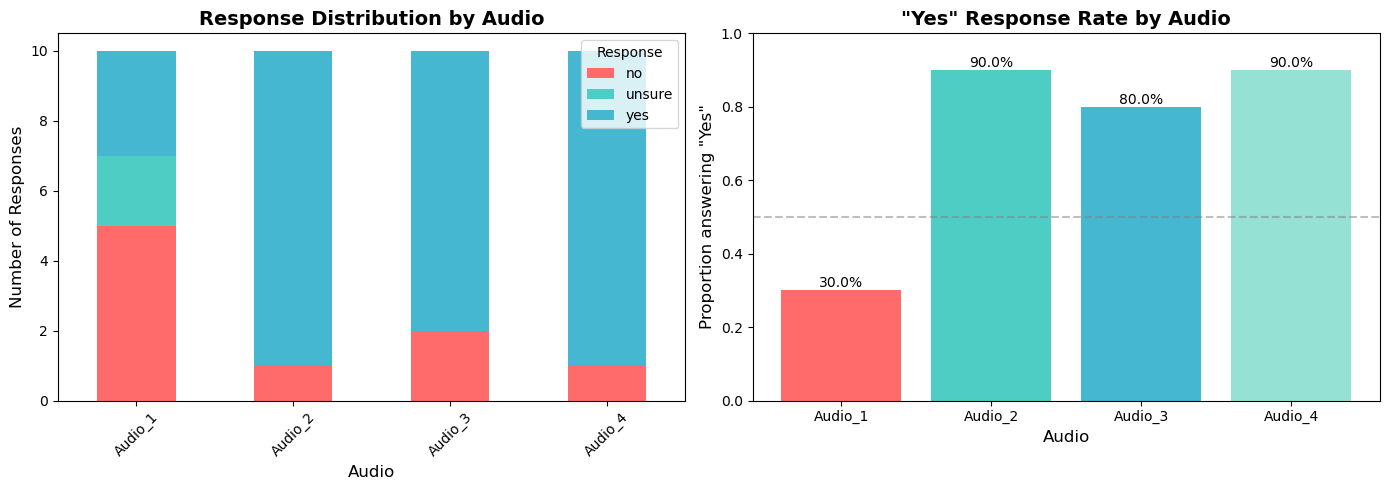

In [76]:

from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import multipletests

# print format of results partially generated by claude, edited down

data = pd.DataFrame({
    'Audio_1': ['yes', 'no', 'unsure', 'yes', 'no', 'yes', 'no', 'unsure', 'no', 'no'],
    'Audio_2': ['yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes'],
    'Audio_3': ['yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no'],
    'Audio_4': ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes']
})

print("Sample size:", len(data))

# Chi-Square Test
print("CHI-SQUARE TEST (Overall difference across audios)")

# Create contingency table
contingency_table = pd.DataFrame({
    audio: data[audio].value_counts() 
    for audio in data.columns
}).fillna(0).T

print("\nContingency Table:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("significant: response patterns differ across audios (p < 0.05)")
else:
    print("not significant: no evidence of different patterns across audios")

# watermark *identification*, where "yes" is identification and "no" and "unsure" are failure to identify
print("\nPROPORTION OF 'YES' RESPONSES")

proportions = {}
for audio in data.columns:
    yes_count = (data[audio] == 'yes').sum()
    total = len(data)
    prop = yes_count / total
    proportions[audio] = {'yes_count': yes_count, 'total': total, 'proportion': prop}
    print(f"{audio}: {yes_count}/{total} = {prop:.2%}")


# mcnemar
print("\n\nMCNEMAR'S TEST")

audios = data.columns.tolist()
comparisons = []
p_values = []

# Compare Audio_2 (hybrid watermark) against all others
target_audio = 'Audio_2'
print(f"\nComparing {target_audio} against other audios:\n")

for other_audio in audios:
    if other_audio == target_audio:
        continue
    
    # Create 2x2 contingency table for McNemar
    # Compare binary responses (yes vs not-yes)
    audio1_binary = (data[target_audio] == 'yes').astype(int)
    audio2_binary = (data[other_audio] == 'yes').astype(int)
    
    both_yes = ((audio1_binary == 1) & (audio2_binary == 1)).sum()
    audio1_only = ((audio1_binary == 1) & (audio2_binary == 0)).sum()
    audio2_only = ((audio1_binary == 0) & (audio2_binary == 1)).sum()
    both_no = ((audio1_binary == 0) & (audio2_binary == 0)).sum()
    
    table = np.array([[both_yes, audio2_only], 
                      [audio1_only, both_no]])
    
    # McNemar test
    result = mcnemar(table, exact=True)
    
    comparisons.append(f"{target_audio} vs {other_audio}")
    p_values.append(result.pvalue)
    
    print(f"{target_audio} vs {other_audio}:")
    print(f"  2x2 table:")
    print(f"    Both 'yes': {both_yes}, Only {target_audio}: {audio1_only}")
    print(f"    Only {other_audio}: {audio2_only}, Both 'no/unsure': {both_no}")
    print(f"  McNemar p-value: {result.pvalue:.4f}")

# VISUALIZATION
print("\n\n5. VISUALIZATION")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Stacked bar chart
response_counts = pd.DataFrame({
    audio: data[audio].value_counts() 
    for audio in data.columns
}).T.fillna(0)

response_counts.plot(kind='bar', stacked=True, ax=axes[0], 
                     color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[0].set_title('Response Distribution by Audio', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Audio', fontsize=12)
axes[0].set_ylabel('Number of Responses', fontsize=12)
axes[0].legend(title='Response')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot 2: Proportion of "yes" responses
yes_props = [proportions[audio]['proportion'] for audio in audios]
bars = axes[1].bar(audios, yes_props, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#95e1d3'])
axes[1].set_title('"Yes" Response Rate by Audio', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Audio', fontsize=12)
axes[1].set_ylabel('Proportion answering "Yes"', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# print("\n✓ Analysis complete!")

### Objective Perceptual Evaluation

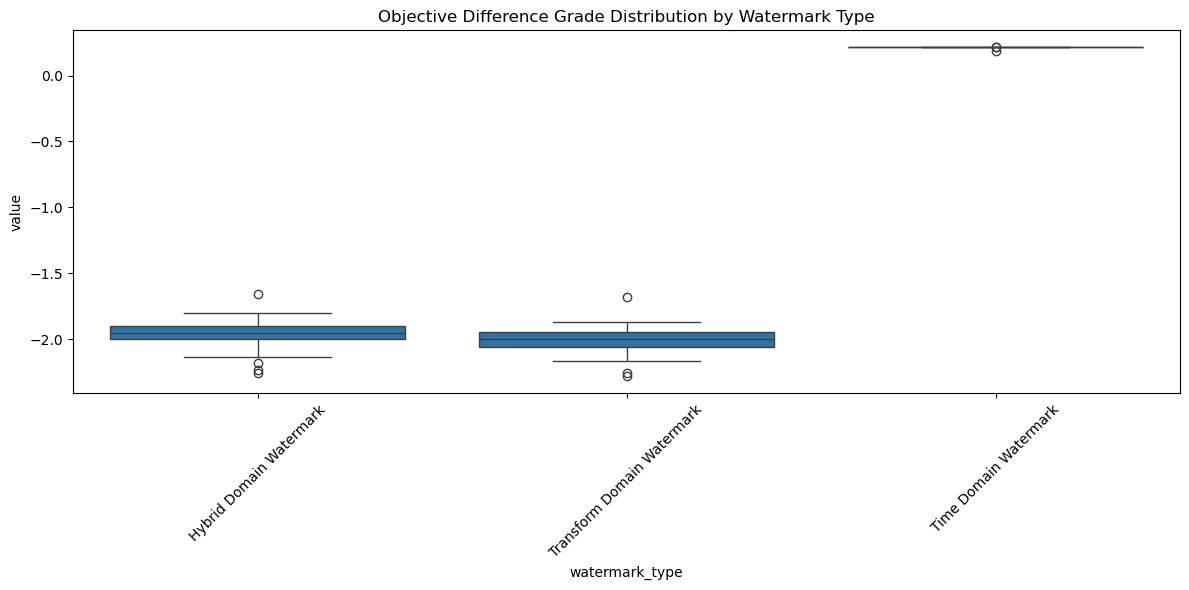

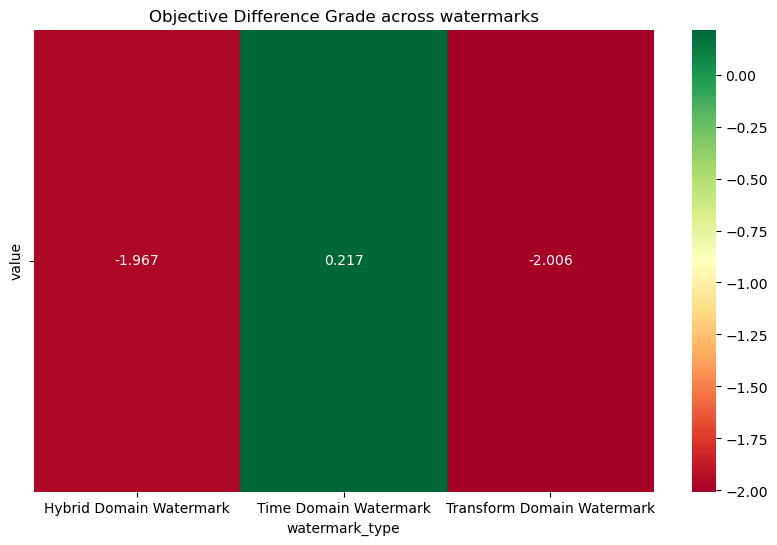

In [57]:
# Perceptual ODG
all_graphs(df=df_perceptual, type=evaluation_type.PERCEPTUAL, metric_number=0) 

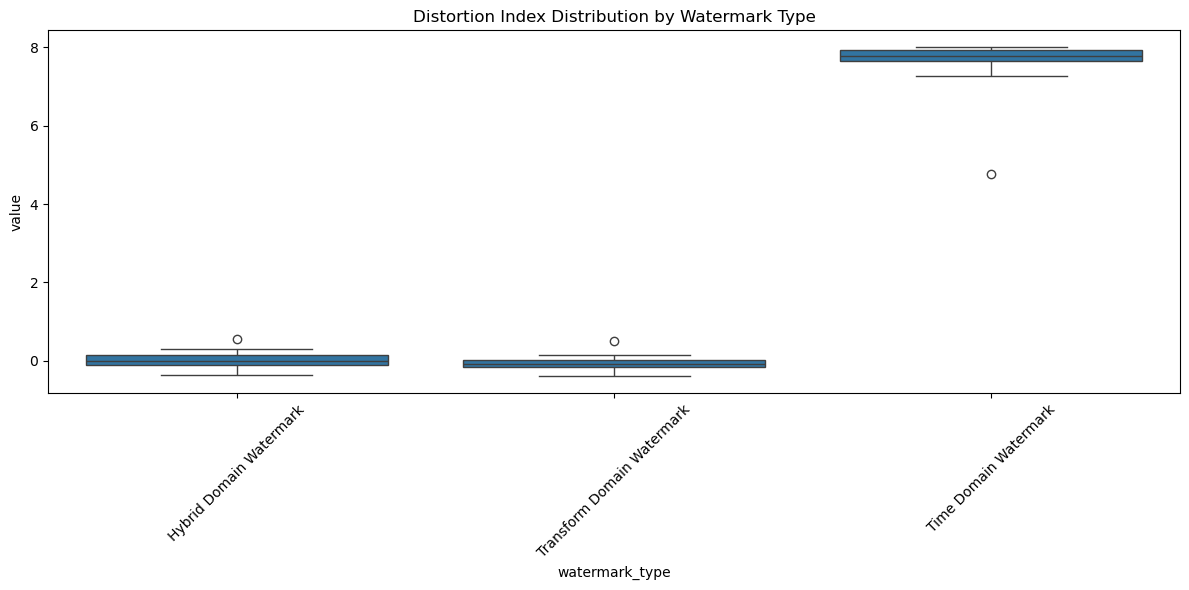

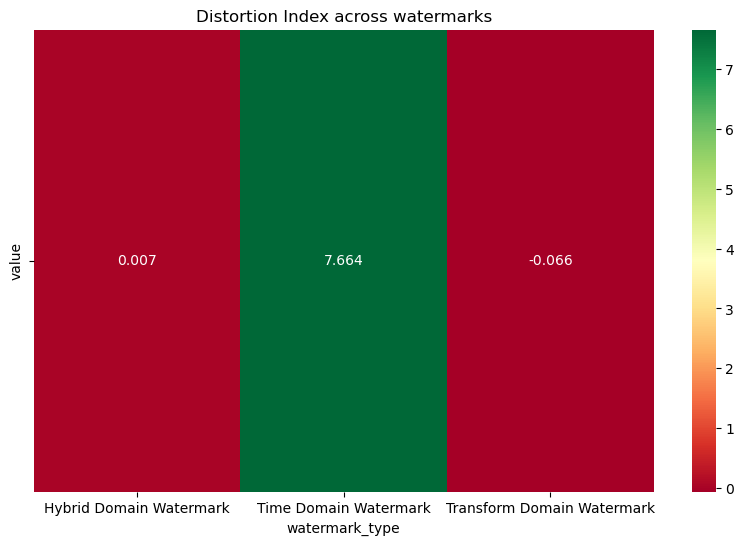

In [58]:
all_graphs(df=df_perceptual, type=evaluation_type.PERCEPTUAL, metric_number=1) 

like odg, the model judged time domain to be higher quality than the original audio (like ODG, positive means better than original). 
it judged the hybrid domain to have ok quality but much lower than time, whereas transform domain was slightly lower than hybrid, but not significantly in the negatives. 

### watermark recovery

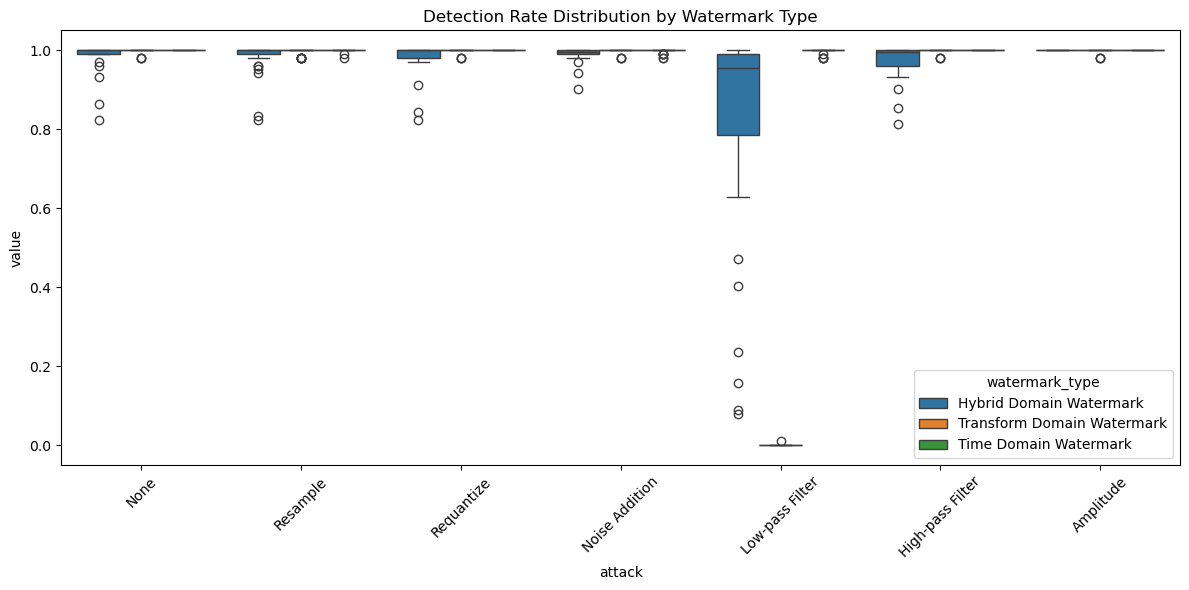

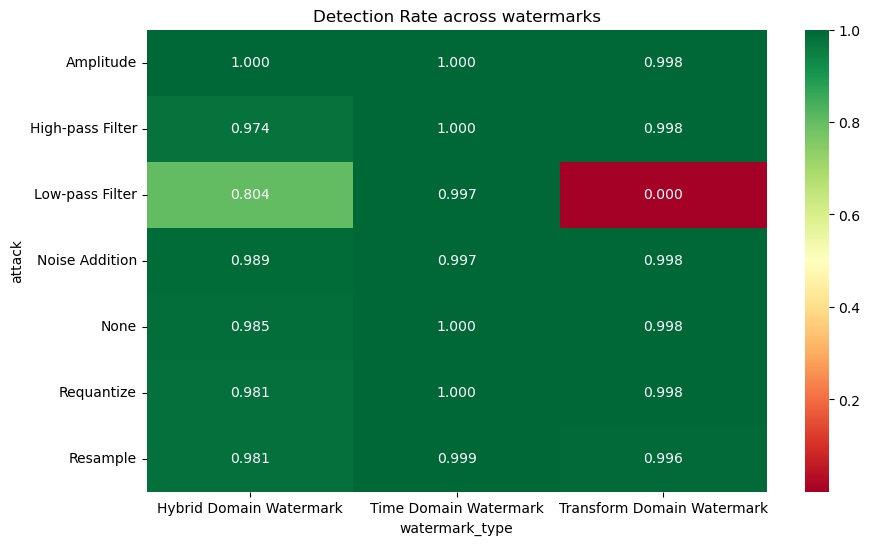

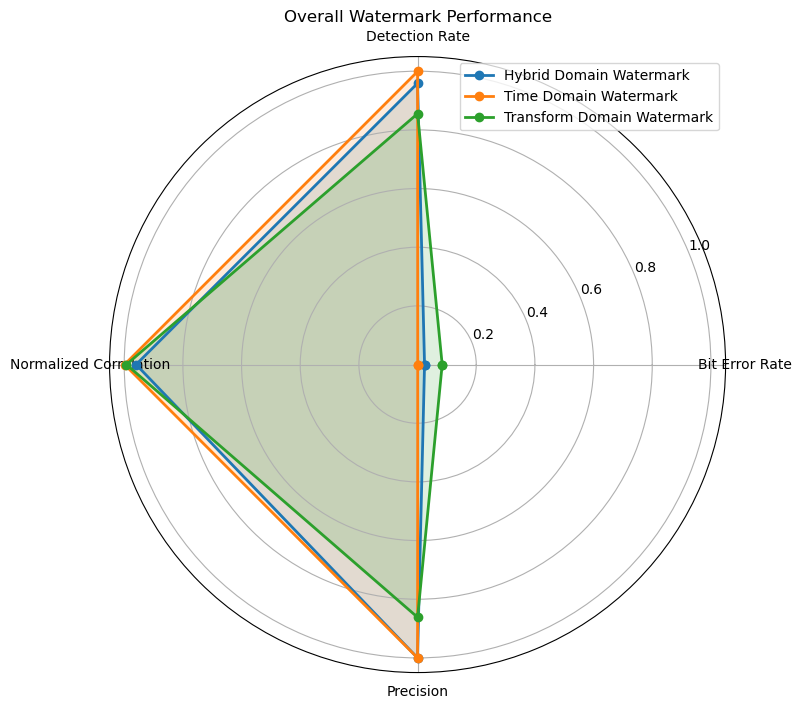

In [60]:
all_graphs(df=df_robust, type=evaluation_type.ROBUST, metric_number=0) 

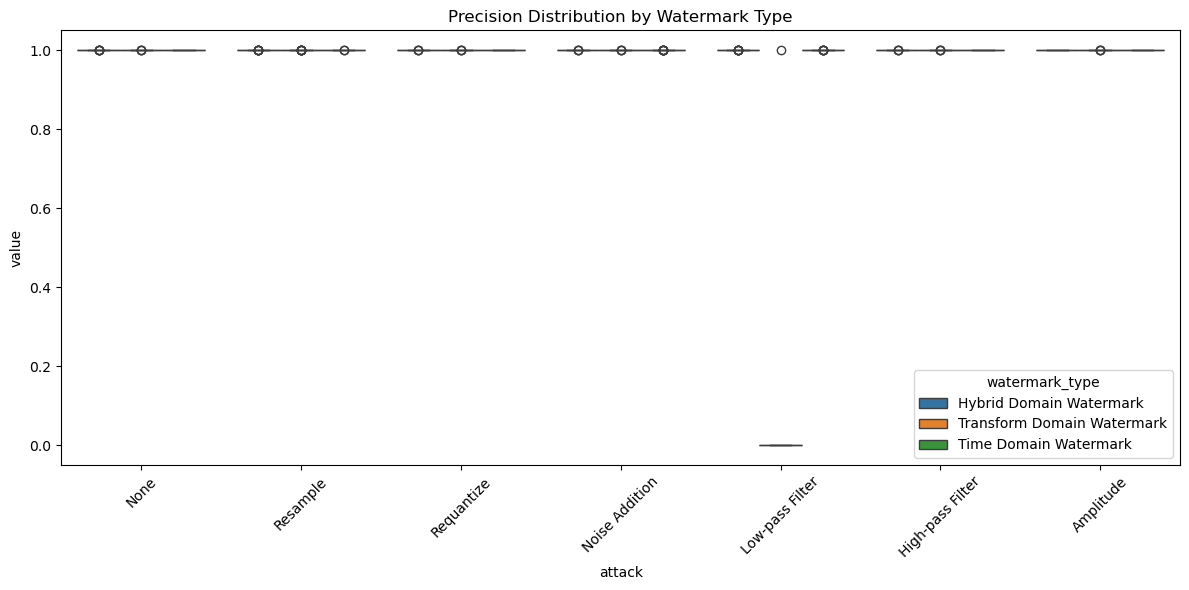

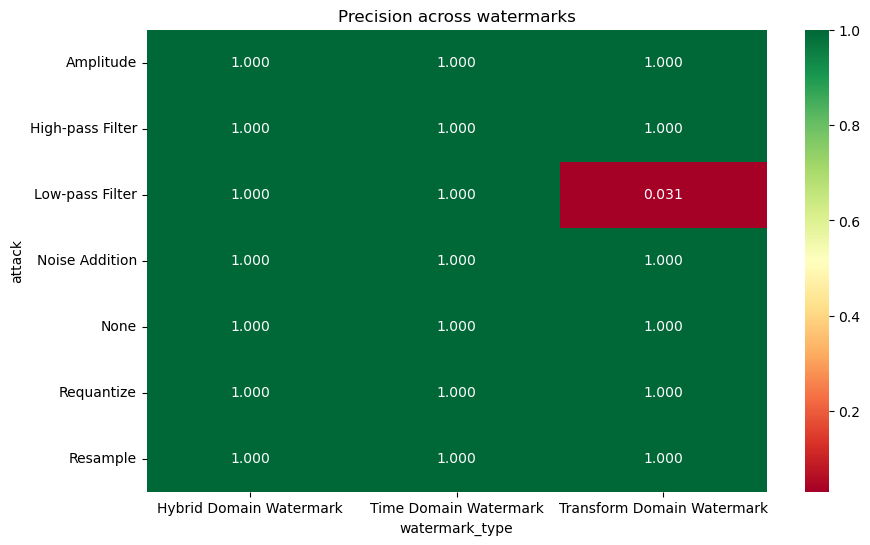

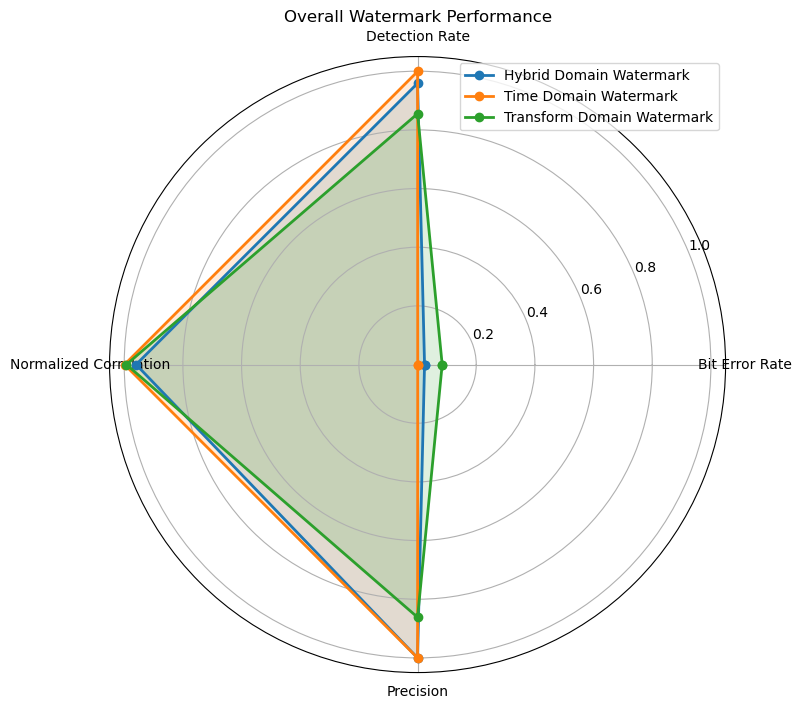

In [61]:
all_graphs(df=df_robust, type=evaluation_type.ROBUST, metric_number=1) 

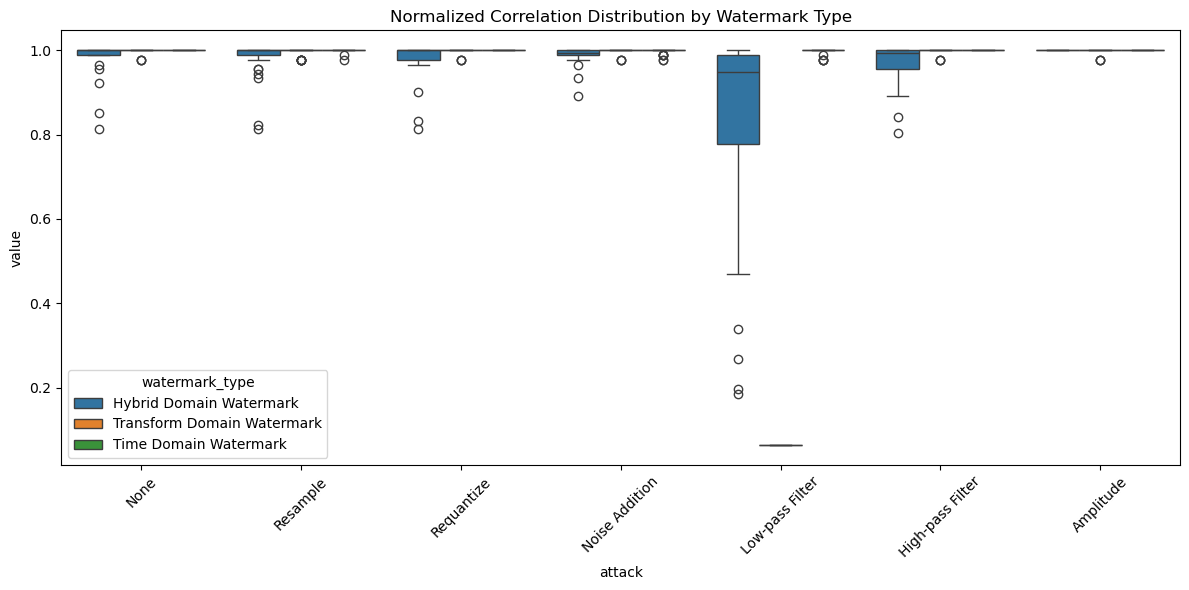

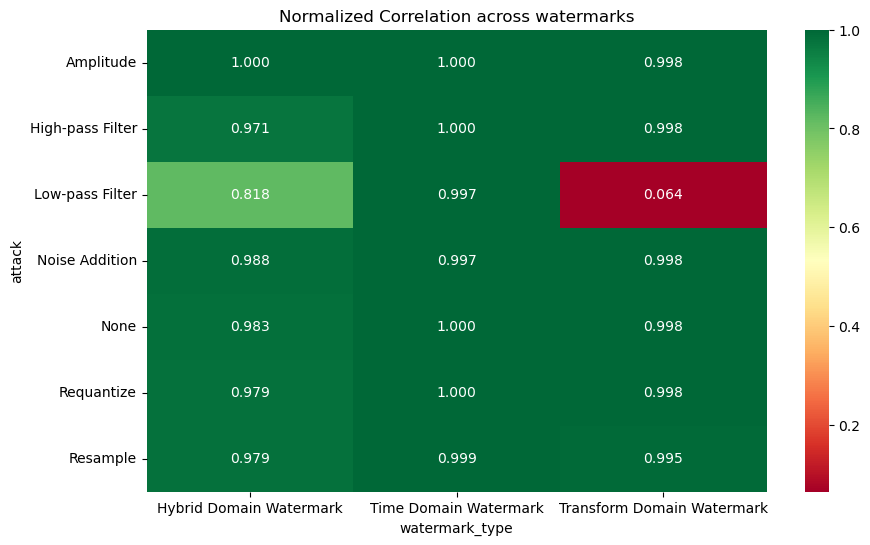

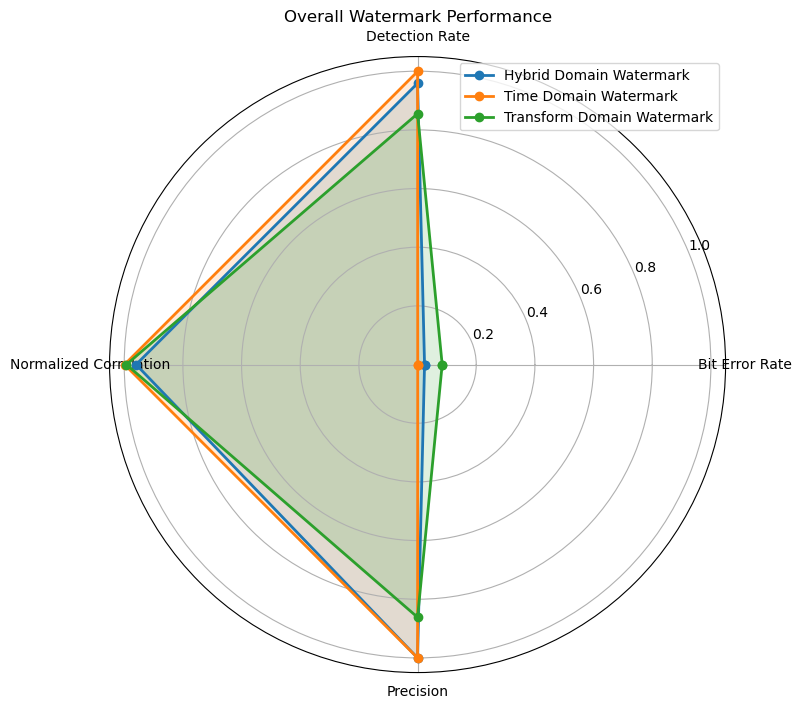

In [62]:
all_graphs(df=df_robust, type=evaluation_type.ROBUST, metric_number=2) 

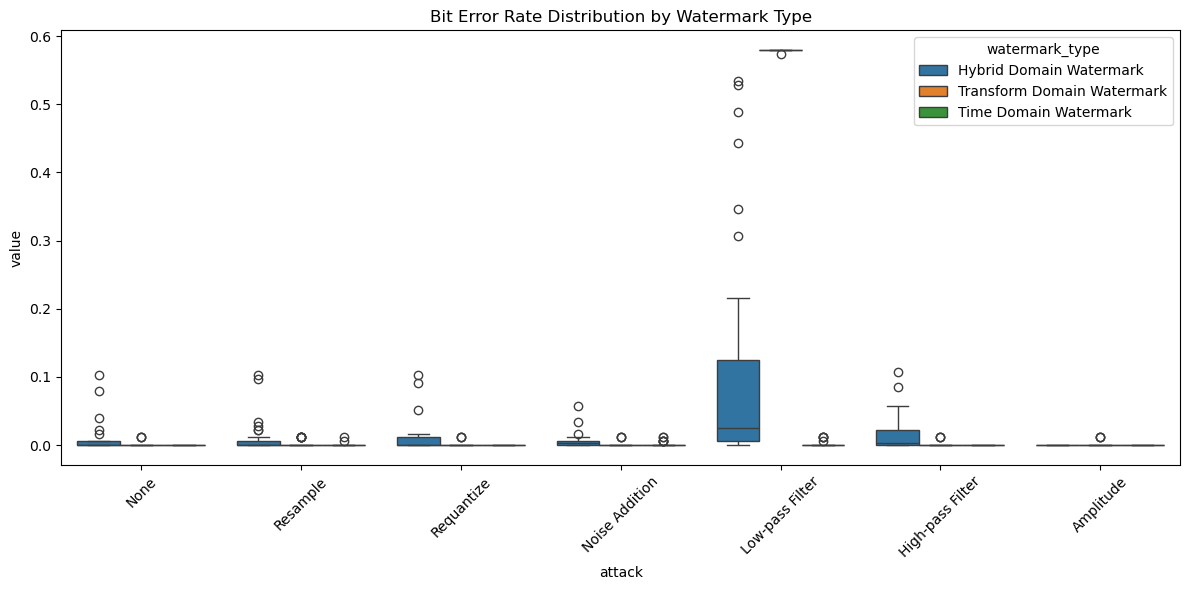

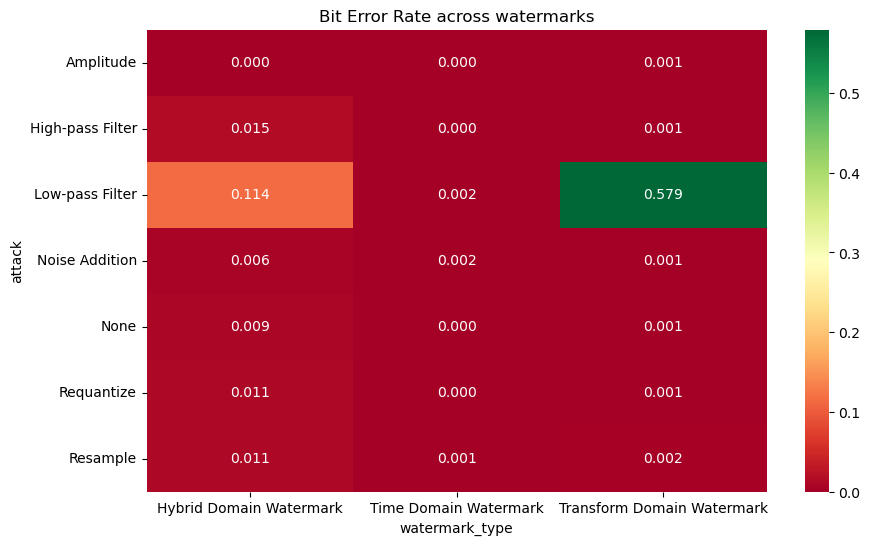

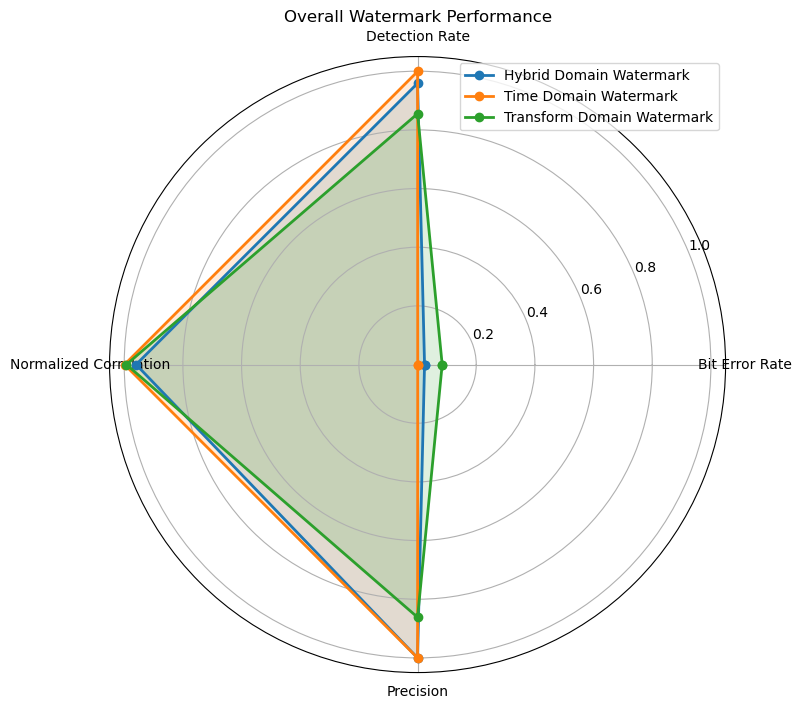

In [63]:
all_graphs(df=df_robust, type=evaluation_type.ROBUST, metric_number=3) 

### bitwise recovery

looking at full embedded bits instead of watermark recovery:

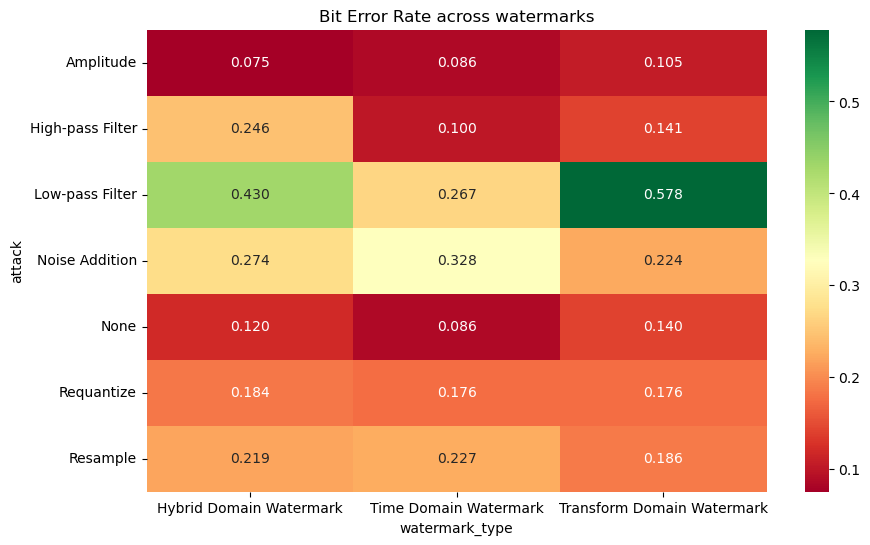

In [71]:
with open("saved_older_data_robust.json", "r") as f:
    f_js = f.read()
    all_bits_results_robust = json.loads(f_js)

df_all_bits_robust = pd.DataFrame(all_bits_results_robust)

heat_map(df = df_all_bits_robust, type = evaluation_type.ROBUST, metric_number = 3)